In [ ]:
#!/usr/bin/env python

r"""
Module defines a class and routines for managing storm best-track type input and
testing reconstructed wind and pressure fields.  Additionally some support for
ensembles of storms from various providers is also included.

The primary class of interest in the module is the `Storm` class that
facilitates dealing with various best-track formats found around the world and
the expected GeoClaw storm format that is read into the FORTRAN code.  The basic
workflow in a `setrun.py` file would do the following:

1. Create a `Storm` object by reading in from a file::

    storm = clawpack.geoclaw.surge.storm.Storm("my_storm.txt", file_format='ATCF')

2. Write out the storm object created into the GeoClaw format::

    storm.write("my_geoclaw_storm.txt", file_format="geoclaw")

3. Specify the path to the GeoClaw formatted storm file, in this case
   "my_geoclaw_storm.txt".

:Formats Supported:
    - GeoClaw (fully)
    - ATCF (reading only)
    - HURDAT (reading only)
    - IBTrACS (reading only)
    - JMA (reading only)
    - IMD (planned)
    - tcvitals (reading only)
"""

from __future__ import print_function
from __future__ import absolute_import
from six.moves import range

import warnings
import sys
import os
import argparse
import datetime

import numpy

import clawpack.geoclaw.units as units
import clawpack.clawutil.data

# =============================================================================
#  Common acronyms across formats

# ATCF basins with their expanded names
# see https://www.nrlmry.navy.mil/atcf_web/docs/database/new/abrdeck.html
ATCF_basins = {"AL": "Atlantic",
               "CP": "Central Pacific",
               "EP": "East Pacific",
               "IO": "North Indian Ocean",
               "SH": "Southern Hemisphere",
               "SL": "Southern Atlantic",
               "LS": "Southern Atlantic",
               "WP": "North West Pacific"}

# TCVitals basins with their expanded names
# see http://www.emc.ncep.noaa.gov/HWRF/tcvitals-draft.html
TCVitals_Basins = {"L": "North Atlantic",
                   "E": "North East Pacific",
                   "C": "North Central Pacific",
 		   "W": "North West Pacific",
		   "B": "Bay of Bengal (North Indian Ocean)",
		   "A": "Arabian Sea (North Indian Ocean)",
		   "Q": "South Atlantic",
		   "P": "South Pacific",
		   "S": "South Indian Ocean"}

# Tropical Cyclone Designations
# see https://www.nrlmry.navy.mil/atcf_web/docs/database/new/abrdeck.html
TC_designations = {"DB": "disturbance",
                   "TD": "tropical depression",
                   "TS": "tropical storm",
                   "TY": "typhoon",
                   "ST": "super typhoon",
                   "TC": "tropical cyclone",
                   "HU": "hurricane",
                   "SD": "subtropical depression",
                   "SS": "subtropical storm",
                   "EX": "extratropical systems",
                   "IN": "inland",
                   "DS": "dissipating",
                   "LO": "low",
                   "WV": "tropical wave",
                   "ET": "extrapolated",
                   "XX": "unknown"}

# HURDAT special designations
# see http://www.aoml.noaa.gov/hrd/data_sub/newHURDAT.html
hurdat_special_entries = {"L": "landfall",
                          "W": "max wind",
                          "P": "min pressure",
                          "I": "max intensity",
                          "C": "closest approach",
                          "S": "status change",
                          "G": "genesis",
                          "T": "additional track point"}


# Warning for formats that have yet to have a default way to determine crticial
# radii from the input data
missing_data_warning_str = """*** Cannot yet automatically determine the
    maximum wind radius.  Will write out GeoClaw
    formats but note that these will not work
    when running GeoClaw currently without a custom
    `max_wind_radius_fill` function passed as argument
    to the `write` function."""

# Warning for not having any time points with both a max wind speed and central
# pressure observation
missing_necessary_data_warning_str = """No storm points in the input file
    had both a max wind speed and a central pressure observation."""

class NoDataError(ValueError):
    """Exception to raise when no valid data in input file"""
    pass


# =============================================================================
#  Basic storm class
class Storm(object):
    r"""
    Storm data object

    This object contains a time series of time data that describe a particular
    storm.  This includes the attributes below and the ability to read from
    multiple sources for data such as the U.S. National Hurricane Center (NHC),
    the Japanese Meterological Agency (JMA), and the Indian Meteorlogical
    Department (IMD).  This class can then write out in any of these formats,
    construct the wind and pressure fields using a supported parameterized
    model, or output the GeoClaw supported storm format used for running storm
    surge simulations.

    *TODO:*  Add description of unit handling

    :Attributes:
     - *t* (list(datetime.datetiem)) Contains the time at which each entry of
       the other arrays are at.  These are expected to be *datetime* objects.
       Note that when written some formats require a *time_offset* to be set.
     - *eye_location* (ndarray(:, :)) location of the eye of the storm.
       Default units are in signed decimcal longitude and latitude.
     - *max_wind_speed* (ndarray(:)) Maximum wind speed.  Default units are
       meters/second.
     - *max_wind_radius* (ndarray(:)) Radius at which the maximum wind speed
       occurs.  Default units are meters.
     - *central_pressure* (ndarray(:)) Central pressure of storm.  Default
       units are Pascals.
     - *storm_radius* (ndarray(:)) Radius of storm, often defined as the last
       closed iso-bar of pressure.  Default units are meters.
     - *time_offset* (datetime.datetime) A date time that as an offset for the
       simulation time.  This will default to the beginning of the first of the
       year that the first time point is found in.
     - *wind_speeds* (ndarray(:, :)) Wind speeds defined in every record, such
       as 34kt, 50kt, 64kt, etc and their radii. Default units are meters/second
       and meters.

    :Initialization:
     1. Read in existing file at *path*.
     2. Construct an empty storm and supply the fields needed.  Note that these
        fields must be converted to the appropriate units.

    :Input:
     - *path* (string) Path to file to be read in if requested.
     - *file_format* (string) Format of file at path.  Default is "hurdat"
     - *kwargs* (dict) Other key-word arguments are passed to the appropriate
       read routine.
    """

    # Define supported formats and models - keys are function name related and
    # values are the proper name and a citation or URL documenting the format
    _supported_formats = {"geoclaw": ["GeoClaw", "http://www.clawpack.org/storms"],
                          "atcf": ["ATCF", "http://www.nrlmry.navy.mil/atcf_web/docs/database/new/database.html"],
                          "hurdat": ["HURDAT", "http://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html"],
                          "ibtracs": ["IBTrACS", "https://www.ncdc.noaa.gov/ibtracs/index.php?name=ib-v4-access"],
                          "jma": ["JMA", "http://www.jma.go.jp/jma/jma-eng/jma-center/rsmc-hp-pub-eg/Besttracks/e_format_bst.html"],
                          "imd": ["IMD", "http://www.rsmcnewdelhi.imd.gov.in/index.php"],
                          "tcvitals": ["TC-Vitals", "http://www.emc.ncep.noaa.gov/mmb/data_processing/tcvitals_description.htm"]}

    def __init__(self, path=None, file_format="ATCF", **kwargs):
        r"""Storm Initiatlization Routine

        See :class:`Storm` for more info.
        """

        self.t = None
        self.time_offset = None
        self.eye_location = None
        self.max_wind_speed = None
        self.max_wind_radius = None
        self.central_pressure = None
        self.storm_radius = None
        self.wind_speeds = None

        # Storm descriptions - not all formats provide these
        self.name = None
        self.basin = None                   # Basin containing storm
        self.ID = None                      # ID code - depends on format
        self.classification = None          # Classification of storm (e.g. HU)
        self.event = None                   # Event (e.g. landfall) - HURDAT

        if path is not None:
            self.read(path, file_format=file_format, **kwargs)

    # ==========================================================================
    #  Basic object support
    def __str__(self):
        r""""""
        output = "Name: %s" % self.name
        output = "\n".join((output, "Dates: %s - %s" % (self.t[0].isoformat(),
                                                        self.t[-1].isoformat())
                            ))
        return output

    def __repr__(self):
        return '<{}.{} "{}" at {}>'.format(
            self.__class__.__module__,
            self.__class__.__name__,
            self.__dict__.get('name', 'name not given'),
            hex(id(self)))

    # ==========================================================================
    # Read Routines
    def read(self, path=None, file_format="atcf", **kwargs):
        r"""Read in storm data from *path* with format *file_format*

        :Input:
         - *path* (string) Path to data file.
         - *file_format* (string) Format of the data file.  See list of
           supported formats for a list of valid strings.  Defaults to
           "hurdat".
         - *kwargs* (dict) Keyword dictionary for additional arguments that can
           be passed down to the appropriate read functions.  Please refer to
           the specific routine for a list of valid options.

        :Raises:
         - *ValueError* If the *file_format* requested does not match any of
           the available supported formats a *ValueError* is raised.
        """

        # If a path is not provided then we can try and find the relevant
        # database and download it
        if path is None:
            data_str = ("Currently automatic download of storm databases is ",
                        "not implemented.  Please refer to the URLs below for",
                        "references as to where you can download storm data",
                        "files:",
                        " - ATCF - http://ftp.nhc.noaa.gov/atcf/archive/",
                        " - HURDAT - http://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html",
                        " - IBTrACS - https://www.ncdc.noaa.gov/ibtracs/index.php?name=ib-v4-access",
                        " - JMA - http://www.jma.go.jp/jma/jma-eng/jma-center/rsmc-hp-pub-eg/besttrack.html",
                        " - IMD - http://www.rsmcnewdelhi.imd.gov.in/index.php",
                        " - TCVITALS - http://www.emc.ncep.noaa.gov/mmb/data_processing/tcvitals_description.htm")
            raise NotImplementedError("\n".join(data_str))

        if file_format.lower() not in self._supported_formats.keys():
            raise ValueError("File format %s not available." % file_format)

        getattr(self, 'read_%s' % file_format.lower())(path, **kwargs)

    def read_geoclaw(self, path, verbose=False):
        r"""Read in a GeoClaw formatted storm file

        GeoClaw storm files are read in by the Fortran code and are not meant
        to be human readable.

        :Input:
         - *path* (string) Path to the file to be read.
         - *verbose* (bool) Output more info regarding reading.
        """

        with open(path, 'r') as data_file:
            num_casts = int(data_file.readline())
            self.time_offset = datetime.datetime.strptime(
                                                      data_file.readline()[:19],
                                                      '%Y-%m-%dT%H:%M:%S')

        data = numpy.loadtxt(path, skiprows=3)
        num_forecasts = data.shape[0]
        self.eye_location = numpy.empty((2, num_forecasts))
        assert(num_casts == num_forecasts)
        self.t = [self.time_offset + datetime.timedelta(seconds=data[i, 0])
                  for i in range(num_forecasts)]
        self.eye_location[0, :] = data[:, 1]
        self.eye_location[1, :] = data[:, 2]
        self.max_wind_speed = data[:, 3]
        self.max_wind_radius = data[:, 4]
        self.central_pressure = data[:, 5]
        self.storm_radius = data[:, 6]

    def read_atcf(self, path, verbose=False):
        r"""Read in a ATCF formatted storm file

        ATCF format has storm stored individually so there is no support for
        multiple storms in a particular file.

        :Input:
         - *path* (string) Path to the file to be read.
         - *verbose* (bool) Output more info regarding reading.
        """
        try:
            import pandas as pd
        except ImportError as e:
            print("read_atcf currently requires pandas to work.")
            raise e

        # See here for the ATCF format documentation:
        #   https://www.nrlmry.navy.mil/atcf_web/docs/database/new/abdeck.txt
        df = pd.read_csv(path, engine="python", sep=",+", names=[
                "BASIN", "CY", "YYYYMMDDHH", "TECHNUM", "TECH", "TAU",
                "LAT", "LON", "VMAX", "MSLP", "TY",
                "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
                "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION",
                "MAXSEAS", "INITIALS", "DIR", "SPEED", "STORMNAME", "DEPTH",
                "SEAS", "SEASCODE", "SEAS1", "SEAS2", "SEAS3", "SEAS4",
                "USERDEFINE1", "userdata1",
                "USERDEFINE2", "userdata2",
                "USERDEFINE3", "userdata3",
                "USERDEFINE4", "userdata4",
                "USERDEFINE5", "userdata5",
            ],
            converters={
                "YYYYMMDDHH": lambda d: datetime.datetime(
                    int(d[1:5]), int(d[5:7]), int(d[7:9]), int(d[9:11])),
                "TAU": lambda d: datetime.timedelta(hours=int(d)),
                "LAT": lambda d: (-.1 if d[-1] == "S" else .1) * int(d.strip("NS ")),
                "LON": lambda d: (-.1 if d[-1] == "W" else .1) * int(d.strip("WE ")),
            },
            dtype={
                "BASIN": str,
                "CY": int,
                "VMAX": float,
                "MSLP": float,
                "TY": str,
                "RAD": float,
                "RAD1": float,
                "RAD2": float,
                "RAD3": float,
                "RAD4": float,
                "ROUTER": float,
                "RMW": float,
            })

        # Grab data regarding basin and cyclone number from first row
        self.basin = ATCF_basins[df["BASIN"][0]]
        self.ID = df["CY"][0]

        # Take forecast period TAU into consideration
        df['DATE'] = df["YYYYMMDDHH"] + df["TAU"]
        df = df[["DATE", "TAU", "TY", "LAT", "LON", "VMAX", "MSLP",
                 "ROUTER", "RMW", "RAD", "RAD1", "RAD2", "RAD3", "RAD4",]]
        df = df.sort_values(by=["DATE", "TAU"]).reset_index(drop=True)


        # For each DATE, choose best (smallest TAU) available data
        for c in ["LAT", "LON", "VMAX", "MSLP", "ROUTER", "RMW",
                  "RAD", "RAD1", "RAD2", "RAD3", "RAD4"]:
            df[c] = df[c].where(df[c] != 0, numpy.nan)  # value 0 means NaN
            df[c] = df.groupby("DATE")[c].fillna(method="bfill")
        df = df.groupby("DATE").first()

        # Wind profile (occasionally missing for older ATCF storms)
        # Wind speeds and their radii
        df["RAD_MEAN"] = df[["RAD1", "RAD2", "RAD3", "RAD4"]].mean(axis=1, skipna=True)
        df = df.drop(["TAU", "RAD1", "RAD2", "RAD3", "RAD4"], axis=1)
        df = df.dropna(how="any", subset=["LAT", "LON"])

        # Create time
        self.t = list(df.index.to_pydatetime())

        # Classification, note that this is not the category of the storm
        self.classification = df["TY"].to_numpy()

        # Eye location - longitude/latitude order
        self.eye_location = df[["LON", "LAT"]].to_numpy()

        # Convert to correct units:
        #  max_wind_speed - Convert knots to m/s - 0.51444444
        #  max_wind_radius  - convert from nm to m - 1.8520000031807990 * 1000.0
        #  central_pressure - convert from mbar to Pa - 100.0
        #  Radius of last isobar contour - convert from nm to m - 1.852000003180799d0 * 1000.0
        self.max_wind_speed = units.convert(df["VMAX"].to_numpy(), 'knots', 'm/s')
        self.central_pressure = units.convert(df["MSLP"].to_numpy(), 'mbar', 'Pa')
        self.max_wind_radius = units.convert(df["RMW"].to_numpy(), 'nmi', 'm')
        self.storm_radius = units.convert(df["ROUTER"].to_numpy(), 'nmi', 'm')
        self.wind_speeds = df[["RAD","RAD_MEAN"]].to_numpy()
        self.wind_speeds[:,0] = units.convert(self.wind_speeds[:,0], 'knots', 'm/s')
        self.wind_speeds[:,1] = units.convert(self.wind_speeds[:,1], 'nmi', 'm')

        # Set NaNs to -1 to mark them as missing
        for ar in [self.max_wind_speed, self.central_pressure,
                   self.max_wind_radius, self.storm_radius, self.wind_speeds]:
            ar[numpy.isnan(ar)] = -1.

        if self.max_wind_speed.min() == -1:
            warnings.warn('Some timesteps have missing max wind speed. These will not be written'
                          ' out to geoclaw format.')
        if self.central_pressure.min() == -1:
            warnings.warn('Some timesteps have missing central pressure. These will not be written'
                          ' out to geoclaw format.')

    def read_hurdat(self, path, verbose=False):
        r"""Read in HURDAT formatted storm file

        This is the current version of HURDAT data available (HURDAT 2).  Note
        that this assumes there is only one storm in the file (includes the
        header information though).  Future features will be added that will allow for
        a file to be read with multiple storms defined.

        For more details on the HURDAT format and getting data see

        http://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html

        :Input:
         - *path* (string) Path to the file to be read.
         - *verbose* (bool) Output more info regarding reading.

        :Raises:
         - *ValueError* If the method cannot find the name/year matching the
           storm or they are not provided when *single_storm == False* then a
           value error is risen.
        """

        with open(path, 'r') as hurdat_file:
            # Extract header
            data = [value.strip() for value in
                    hurdat_file.readline().split(',')]
            self.basin = data[0][:2]
            self.name = data[1]
            self.ID = data[2]

            # Store rest of data
            data_block = hurdat_file.readlines()

        num_lines = len(data_block)

        # Parse data block
        self.t = []
        self.event = numpy.empty(num_lines, dtype=str)
        self.classification = numpy.empty(num_lines, dtype=str)
        self.eye_location = numpy.empty((num_lines, 2))
        self.max_wind_speed = numpy.empty(num_lines)
        self.central_pressure = numpy.empty(num_lines)
        self.max_wind_radius = numpy.empty(num_lines)
        self.storm_radius = numpy.empty(num_lines)

        for (i, line) in enumerate(data_block):
            if len(line) == 0:
                break
            data = [value.strip() for value in line.split(",")]

            # Create time
            self.t.append(datetime.datetime(int(data[0][:4]),
                                            int(data[0][4:6]),
                                            int(data[0][6:8]),
                                            int(data[1][:2]),
                                            int(data[1][2:])))

            # If an event is occuring record it.  If landfall then use as an
            # offset.   Note that if there are multiple landfalls the last one
            # is used as the offset
            if len(data[2].strip()) > 0:
                self.event[i] = data[2].strip()
                if self.event[i].upper() == "L":
                    self.time_offset = self.t[i]

            # Classification, note that this is not the category of the storm
            self.classification[i] = data[3]

            # Parse eye location
            if data[4][-1] == "N":
                self.eye_location[i, 1] = float(data[4][0:-1])
            else:
                self.eye_location[i, 1] = -float(data[4][0:-1])
            if data[5][-1] == "E":
                self.eye_location[i, 0] = float(data[5][0:-1])
            else:
                self.eye_location[i, 0] = -float(data[5][0:-1])

            # Intensity information - radii are not included directly in this
            # format and instead radii of winds above a threshold are included
            self.max_wind_speed[i] = units.convert(float(data[6]), 'knots', 'm/s')
            self.central_pressure[i] = units.convert(float(data[7]), 'mbar', 'Pa')
            warnings.warn(missing_data_warning_str)
            self.max_wind_radius[i] = -1
            self.storm_radius[i] = -1

    def read_ibtracs(self, path, sid=None, storm_name=None, year=None, start_date=None,
                     agency_pref = ['wmo',
                                   'usa',
                                   'tokyo',
                                   'newdelhi',
                                   'reunion',
                                   'bom',
                                   'nadi',
                                   'wellington',
                                   'cma',
                                   'hko',
                                   'ds824',
                                   'td9636',
                                   'td9635',
                                   'neumann',
                                   'mlc']):
        r"""Read in IBTrACS formatted storm file

        This reads in the netcdf-formatted IBTrACS v4 data. You must either pass
        the *sid* of the storm (a unique identifier supplied by IBTrACS) OR
        *storm_name* and *year*. The latter will not be unique for unnamed storms,
        so you may optionally pass *start_date* as well. The `wmo_\*` variable is
        used when non-missing, with missing values filled in by the corresponding
        variable of the agency specified in `wmo_agency` and/or `usa_agency`. If
        still missing, the other agencies are checked in order of *agency_pref* to
        see if any more non-missing values are available.

        :Input:
         - *path* (string) Path to the file to be read.
         - *sid* (string, optional) IBTrACS-supplied unique track identifier.
             Either *sid* OR *storm_name* and *year* must not be None.
         - *storm_name* (string, optional) name of storm of interest
             (NAME field in IBTrACS). Either *sid* OR *storm_name* and
             *year* must not be None.
         - *year* (int, optional) year of storm of interest.
             Either *sid* OR *storm_name* and *year* must not be None.
         - *start_date* (:py:class:`datetime.datetime`, optional) If storm is not
             named, will find closest unnamed storm to this start date. Only
             used for unnamed storms when specifying *storm_name* and *year*
             does not uniquely identify storm.
         - *agency_pref* (list, optional) Preference order to use if `wmo_\*` variable
             is missing and `wmo_agency` and `usa_agency` are also missing.

        :Raises:
         - *ValueError* If the method cannot find the matching storm then a
             value error is risen.
        """

        # imports that you don't need for other read functions
        try:
            import xarray as xr
        except ImportError as e:
            print("IBTrACS currently requires xarray to work.")
            raise e

        # only allow one method for specifying storms
        if (sid is not None) and ((storm_name is not None) or (year is not None)):
            raise ValueError('Cannot specify both *sid* and *storm_name* or *year*.')

        with xr.open_dataset(path) as ds:

            # match on sid
            if sid is not None:
                match = ds.sid == sid.encode()
            # or match on storm_name and year
            else:
                storm_name = storm_name.upper()
                # in case storm is unnamed
                if storm_name.upper() in ['UNNAMED','NO-NAME']:
                    storm_name = 'NOT_NAMED'
                storm_match = (ds.name == storm_name.encode())
                year_match = (ds.time.dt.year == year).any(dim='date_time')
                match = storm_match & year_match
            ds = ds.sel(storm=match).squeeze()

            # occurs if we have 0 or >1 matching storms
            if 'storm' in ds.dims.keys():
                if ds.storm.shape[0] == 0:
                    raise ValueError('Storm/year not found in provided file')
                else:
                    # see if a date was provided for multiple unnamed storms
                    assert start_date is not None, ValueError('Multiple storms identified and no start_date specified.')

                    start_times = ds.time.isel(date_time=0)
                    start_date = numpy.datetime64(start_date)

                    # find storm with start date closest to provided
                    storm_ix = abs(start_times - start_date).argmin()
                    ds = ds.isel(storm=storm_ix).squeeze()
                    assert 'storm' not in ds.dims.keys()

            # cut down dataset to only non-null times
            valid_t = ds.time.notnull()
            if valid_t.sum() == 0:
                raise ValueError('No valid wind speeds found for this storm.')
            ds = ds.sel(date_time=valid_t)


            # list of the agencies that correspond to 'usa_*' variables
            usa_agencies = [b'atcf', b'hurdat_atl', b'hurdat_epa', b'jtwc_ep',
                           b'nhc_working_bt', b'tcvightals', b'tcvitals']


            ## Create mapping from wmo_ or usa_agency
            ## to the appropriate variable
            agency_map = {b'':agency_pref.index('wmo')}
            # account for multiple usa agencies
            for a in usa_agencies:
                agency_map[a] = agency_pref.index('usa')
            # map all other agencies to themselves
            for i in [a for a in agency_pref if a not in ['wmo','usa']]:
                agency_map[i.encode('utf-8')] = agency_pref.index(i)

            # fill in usa as provider if usa_agency is
            # non-null when wmo_agency is null
            provider = ds.wmo_agency.where(ds.wmo_agency!=b'',ds.usa_agency)

            # get index into from agency that is wmo_provider
            def map_val_to_ix(a):
                func = lambda x: agency_map[x]
                return xr.apply_ufunc(func,a, vectorize=True)
            pref_agency_ix=map_val_to_ix(provider)

            ## GET MAX WIND SPEED and PRES
            pref_vals = {}
            for v in ['wind','pres']:
                all_vals = ds[['{}_{}'.format(i,v) for i in agency_pref]].to_array(dim='agency')

                # get wmo value
                val_pref = ds['wmo_'+v]

                # fill this value in as a second-best
                pref_2 = all_vals.isel(agency=pref_agency_ix)
                val_pref = val_pref.fillna(pref_2)

                # now use the agency_pref order to fill in
                # any remaining values as third best
                best_ix = all_vals.notnull().argmax(dim='agency')
                pref_3 = all_vals.isel(agency=best_ix)
                val_pref = val_pref.fillna(pref_3)

                # add to dict
                pref_vals[v] = val_pref


            ## THESE CANNOT BE MISSING SO DROP
            ## IF EITHER MISSING
            valid = pref_vals['wind'].notnull() & pref_vals['pres'].notnull()
            if not valid.any():
                raise NoDataError(missing_necessary_data_warning_str)
            ds = ds.sel(date_time=valid)
            for i in ['wind','pres']:
                pref_vals[i] = pref_vals[i].sel(date_time=valid)


            ## GET RMW and ROCI
            ## (these can be missing)
            for r in ['rmw','roci']:
                order = ['{}_{}'.format(i,r) for i in agency_pref if
                                 '{}_{}'.format(i,r) in ds.data_vars.keys()]
                vals = ds[order].to_array(dim='agency')
                best_ix = vals.notnull().argmax(dim='agency')
                val_pref = vals.isel(agency=best_ix)
                pref_vals[r] = val_pref


            ## CONVERT TO GEOCLAW FORMAT

            # assign basin to be the basin where track originates
            # in case track moves across basins
            self.basin = ds.basin.values[0].astype(str)
            self.name = ds.name.astype(str).item()
            self.ID = ds.sid.astype(str).item()

            # convert datetime64 to datetime.datetime
            self.t = []
            for d in ds.time:
                t = d.dt
                self.t.append(datetime.datetime(t.year,t.month,t.day,t.hour,t.minute,t.second))

            ## events
            self.event = ds.usa_record.values.astype(str)

            ## time offset
            if (self.event=='L').any():
                # if landfall, use last landfall
                self.time_offset = numpy.array(self.t)[self.event=='L'][-1]
            else:
                #if no landfall, use last time of storm
                self.time_offset = self.t[-1]

            # Classification, note that this is not the category of the storm
            self.classification = ds.usa_status.values
            self.eye_location = numpy.array([ds.lon,ds.lat]).T

            # Intensity information - for now, including only common, basic intensity
            # info.
            # TODO: add more detailed info for storms that have it
            self.max_wind_speed = units.convert(pref_vals['wind'],'knots','m/s').where(pref_vals['wind'].notnull(),-1).values
            self.central_pressure = units.convert(pref_vals['pres'],'mbar','Pa').where(pref_vals['pres'].notnull(),-1).values
            self.max_wind_radius = units.convert(pref_vals['rmw'],'nmi','m').where(pref_vals['rmw'].notnull(),-1).values
            self.storm_radius = units.convert(pref_vals['roci'],'nmi','m').where(pref_vals['roci'].notnull(),-1).values

            # warn if you have missing vals for RMW or ROCI
            if (self.max_wind_radius.max()) == -1 or (self.storm_radius.max() == -1):
                warnings.warn(missing_data_warning_str)


    def read_jma(self, path, verbose=False):
        r"""Read in JMA formatted storm file

        Note that only files that contain one storm are currently supported.

        For more details on the JMA format and getting data see

        http://www.jma.go.jp/jma/jma-eng/jma-center/rsmc-hp-pub-eg/Besttracks/e_format_bst.html

        :Input:
         - *path* (string) Path to the file to be read.
         - *verbose* (bool) Output more info regarding reading.

        :Raises:
         - *ValueError* If the method cannot find the name/year matching the
           storm or they are not provided when *single_storm == False* then a
           value error is risen.
        """

        data_block = []
        with open(path, 'r') as JMA_file:
            # Extract header
            data = JMA_file.readline()
            self.ID = data[6:10]
            num_lines = int(data[12:14])
            self.name = data[30:51].strip()

            data_block = JMA_file.readlines()
        assert(num_lines == len(data_block))

        # Parse data block
        self.t = []
        self.event = numpy.empty(num_lines, dtype=str)
        self.classification = numpy.empty(num_lines, dtype=str)
        self.eye_location = numpy.empty((num_lines, 2))
        self.max_wind_speed = numpy.empty(num_lines)
        self.central_pressure = numpy.empty(num_lines)
        self.max_wind_radius = numpy.empty(num_lines)
        self.storm_radius = numpy.empty(num_lines)
        for (i, line) in enumerate(data_block):
            if len(line) == 0:
                break
            data = [value.strip() for value in line.split()]

            # Create time
            self.t.append(datetime.datetime(int(data[0][:2]),
                                            int(data[0][2:4]),
                                            int(data[0][4:6]),
                                            int(data[0][6:])))

            # Classification, note that this is not the category of the storm
            self.classification[i] = int(data[1])

            # Parse eye location - Always N latitude and E longitude
            self.eye_location[i, 0] = float(data[4]) / 10.0
            self.eye_location[i, 1] = float(data[3]) / 10.0

            # Intensity information - current the radii are not directly given
            # Available data includes max/min of radius of winds of 50 and
            # 30 kts instead
            self.central_pressure[i] = units.convert(float(data[5]), 'hPa', 'Pa')
            self.max_wind_speed[i] = units.convert(float(data[6]), 'knots', 'm/s')
            warnings.warn(missing_data_warning_str)
            self.max_wind_radius[i] = -1
            self.storm_radius[i] = -1


    def read_imd(self, path, verbose=False):
        r"""Extract relevant hurricane data from IMD file
            and update storm fields with proper values.

        :Input:
         - *path* (string) Path to the file to be read.

        Return ValueError if format incorrect or if file not IMD.
        """
        raise NotImplementedError(("Reading in IMD files is not ",
                                   "implemented yet but is planned for a ",
                                   "future release."))


    def read_tcvitals(self, path, verbose=False):
        r"""Extract relevant hurricane data from TCVITALS file
            and update storm fields with proper values.

        :Input:
         - *path* (string) Path to the file to be read.
         - *verbose* (bool) Output more info regarding reading.

        """

        # read in TCVitals_file
        data_block = []
        with open(path, 'r') as TCVitals_file:
            data = TCVitals_file.readlines()
            for line in data:
                line = line.split()
                line = [value.strip() for value in line]
                data_block.append(line)
        num_lines = len(data_block)

        # Parse data block - convert to correct units
        # Conversions:
        #  max_wind_radius  - convert from km to m - 1000.0
        #  Central_pressure - convert from mbar to Pa - 100.0
        #  Radius of last isobar contour - convert from km to m - 1000.0
        self.t = []
        self.classification = numpy.empty(num_lines, dtype=str)
        self.eye_location = numpy.empty((num_lines, 2))
        self.max_wind_speed = numpy.empty(num_lines)
        self.central_pressure = numpy.empty(num_lines)
        self.max_wind_radius = numpy.empty(num_lines)
        self.storm_radius = numpy.empty(num_lines)

        for (i, data) in enumerate(data_block):
            # End at an empty lines - skips lines at the bottom of a file
            if len(data) == 0:
                break

            # Grab data regarding basin and cyclone number if we are starting
            if i == 0:
                self.basin = TCVitals_Basins[data[1][2:]]
                self.ID = int(data[1][:2])

            # Create time
            self.t.append(datetime.datetime(int(data[3][0:4]),
                                            int(data[3][4:6]),
                                            int(data[3][6:]),
                                            int(data[4][:2])))

            # Parse eye location - longitude/latitude order
            if data[5][-1] == 'N':
                self.eye_location[i, 1] = float(data[5][0:-1])/10.0
            else:
                self.eye_location[i, 1] = -float(data[5][0:-1])/10.0
            if data[6][-1] == "E":
                self.eye_location[i, 0] = float(data[6][0:-1])/10.0
            else:
                self.eye_location[i, 0] = -float(data[6][0:-1])/10.0

            # Intensity Information
            self.max_wind_speed[i] = float(data[12])
            self.central_pressure[i] = units.convert(float(data[9]), 'mbar', 'Pa')
            self.max_wind_radius[i] = units.convert(float(data[13]), 'km', 'm')
            self.storm_radius[i] = units.convert(float(data[11]), 'km', 'm')


    # =========================================================================
    # Write Routines
    def write(self, path, file_format="geoclaw", **kwargs):
        r"""Write out the storm data to *path* in format *file_format*

        :Input:
         - *path* (string) Path to data file.
         - *file_format* (string) Format of the data file.  See list of
           supported formats for a list of valid strings.  Defaults to
           "geoclaw".
         - *kwargs* (dict) Keyword dictionary for additional arguments that can
           be passed down to the appropriate write functions.  Please refer to
           the specific routine for a list of valid options.

        :Raises:
         - *ValueError* If the *file_format* requested does not match any of
           the available supported formats a *ValueError* is raised.
        """

        if file_format.lower() not in self._supported_formats.keys():
            raise ValueError("File format %s not available." % file_format)

        getattr(self, 'write_%s' % file_format.lower())(path, **kwargs)

    def write_geoclaw(self, path, verbose=False, max_wind_radius_fill=None,
                            storm_radius_fill=None):
        r"""Write out a GeoClaw formatted storm file

        GeoClaw storm files are read in by the GeoClaw Fortran code.

        :Input:
         - *path* (string) Path to the file to be written.
         - *verbose* (bool) Print out additional information when writing.
         - *max_wind_radius_fill* (func) Function that can be used to fill in
           missing data for `max_wind_radius` values.  This defaults to simply
           setting the value to -1.  The function signature should be
           `max_wind_radius(t, storm)` where t is the time of the forecast and
           `storm` is the storm object.  Note that if this or `storm_radius`
           field remains -1 that this data line will be assumed to be redundant
           and not be written out.
         - *storm_radius_fill* (func) Function that can be used to fill in
           missing data for `storm_radius` values.  This defaults to simply
           setting the value to -1.  The function signature should be
           `storm_radius(t, storm)` where t is the time of the forecast and
           `storm` is the storm object.  Note that if this or `max_wind_radius`
           field remains -1 that this data line will be assumed to be redundant
           and not be written
        """

        if max_wind_radius_fill is None:
            max_wind_radius_fill = lambda t, storm: -1
        if storm_radius_fill is None:
            storm_radius_fill = lambda t, storm: -1

        # Create list for output
        # Leave this first line blank as we need to count the actual valid lines
        # that will be left in the file below
        num_casts = 0
        data_string = [""]
        if self.time_offset is None:
            # Use the first time in sequence if not provided
            self.time_offset = self.t[0]
        data_string.append("%s\n\n" % self.time_offset.isoformat())
        for n in range(len(self.t)):
            # Remove duplicate times
            if n > 0:
                if self.t[n] == self.t[n - 1]:
                    continue

            format_string = ("{:19,.8e} " * 7)[:-1] + "\n"
            data = []
            data.append((self.t[n] - self.time_offset).total_seconds())
            data.append(self.eye_location[n, 0])
            data.append(self.eye_location[n, 1])

            if self.max_wind_speed[n] == -1:
                continue
            data.append(self.max_wind_speed[n])

            # Allow custom function to set max wind radius if not
            # available
            if self.max_wind_radius[n] == -1:
                new_wind_radius = max_wind_radius_fill(self.t[n], self)
                if new_wind_radius == -1:
                    continue
                else:
                    data.append(new_wind_radius)
            else:
                data.append(self.max_wind_radius[n])

            if self.central_pressure[n] == -1:
                continue
            data.append(self.central_pressure[n])

            # Allow custom function to set storm radius if not available
            if self.storm_radius[n] == -1:
                new_storm_radius = storm_radius_fill(self.t[n], self)
                if new_storm_radius == -1:
                    continue
                else:
                    data.append(new_storm_radius)
            else:
                data.append(self.storm_radius[n])

            data_string.append(format_string.format(*data))
            num_casts += 1


        # Write to actual file now that we know exactly how many lines it will
        # contain
        try:
            # Update number of forecasts here
            data_string[0] = "%s\n" % num_casts
            with open(path, "w") as data_file:
                for data_line in data_string:
                    data_file.write(data_line)

        except Exception as e:
            # Remove possibly partially generated file if not successful
            if os.path.exists(path):
                os.remove(path)
            raise e

    def write_atcf(self, path, verbose=False):
        r"""Write out a ATCF formatted storm file

        :Input:
         - *path* (string) Path to the file to be written.
         - *verbose* (bool) Print out additional information when writing.
        """
        raise NotImplementedError(("Writing out ATCF files is not implemented ",
                                   "yet but is planned for a future release."))
        try:
            with open(path, 'w') as data_file:
                for n in range(len(self.t)):
                    data_file.write("".join((", " * 2,
                                         "%s" % seconds2date(self.t[n]),
                                         ", " * 4,
                                         "%s" % (int(self.eye_location[n, 0] *
                                                     10.0)),
                                         ", ",
                                         "%s" % (int(self.eye_location[n, 1] *
                                                     10.0)),
                                         ", ",
                                         "%s" % self.max_wind_speed[n],
                                         ", ",
                                         "%s" % self.central_pressure[n],
                                         ", ",
                                         ", " * 8,
                                         "%s" % self.storm_radius[n],
                                         ", ",
                                         "%s" % self.max_wind_radius[n],
                                         ", " * 10,
                                         "\n")))
        except Exception as e:
            # Remove possiblly partially generated file if not successful
            if os.path.exists(path):
                os.remove(path)
            raise e

    def write_hurdat(self, path, verbose=False):
        r"""Write out a HURDAT formatted storm file

        :Input:
         - *path* (string) Path to the file to be written.
         - *verbose* (bool) Print out additional information when writing.
        """
        raise NotImplementedError(("Writing out hurdat files is not ",
                                   "implemented yet but is planned for a ",
                                   "future release."))
        try:
            with open(path, 'w') as data_file:
                data_file.write('%s %s %s' % ("Date", "Hurricane Name",
                                              "Indicator"))
                for n in range(self.t.shape[0]):

                    latitude = float(self.eye_location[n, 0])
                    longitude = float(self.eye_location[n, 1])

                    # Convert latitude to proper Hurdat format e.g 12.0N
                    if latitude > 0:
                        latitude = str(numpy.abs(latitude)) + 'N'
                    else:
                        latitude = str(numpy.abs(latitude)) + 'S'

                    # Convert longitude to proper Hurdat format e.g 12.0W
                    if longitude > 0:
                        longitude = str(numpy.abs(longitude)) + 'E'
                    else:
                        longitude = str(numpy.abs(longitude)) + 'W'

                    data_file.write("".join(("%s" % self.seconds2date(
                                                              self.t[n])[0:-2],
                                         "%s00" % self.seconds2date(
                                                              self.t[n])[-2:],
                                         ", " * 3,
                                         "%s" % (latitude),
                                         ", ",
                                         "%s" % (longitude),
                                         ", ",
                                         "%s" % self.max_wind_speed[n],
                                         ", ",
                                         "%s" % self.central_pressure[n],
                                         ", ",
                                         "%s" % self.storm_radius[n],
                                         ", ",
                                         "%s" % self.max_wind_radius[n],
                                         ", " * 10,
                                         "\n")))
        except Exception as e:
            # Remove possiblly partially generated file if not successful
            if os.path.exists(path):
                os.remove(path)
            raise e

    def write_jma(self, path, verbose=False):
        r"""Write out a JMA formatted storm file

        :Input:
         - *path* (string) Path to the file to be written.
         - *verbose* (bool) Print out additional information when writing.
        """
        raise NotImplementedError(("Writing out JMA files is not implemented ",
                                   "yet but is planned for a future release."))
        try:
            with open(path, 'w') as data_file:
                for n in range(self.t.shape[0]):
                    data_file.write("".join(("%s" % self.seconds2date(self.t[n]),
                                         " " * 4,
                                         "%s" % (int(self.eye_location[n, 0] *
                                                     10.0)),
                                         ", ",
                                         "%s" % (int(self.eye_location[n, 1] *
                                                     10.0)),
                                         ", ",
                                         "%s" % self.max_wind_speed[n],
                                         ", ",
                                         "%s" % self.central_pressure[n],
                                         ", ",
                                         ", " * 8,
                                         "%s" % self.storm_radius[n],
                                         ", ",
                                         "%s" % self.max_wind_radius[n],
                                         ", " * 10,
                                         "\n")))
        except Exception as e:
            # Remove possiblly partially generated file if not successful
            if os.path.exists(path):
                os.remove(path)
            raise e

    def write_imd(self, path, verbose=False):
        r"""Write out an IMD formatted storm file

        :Input:
         - *path* (string) Path to the file to be written.
         - *verbose* (bool) Print out additional information when writing.
        """
        raise NotImplementedError(("Writing out IMD files is not implemented ",
                                   "yet but is planned for a future release."))

    def write_tcvitals(self, path, verbose=False):
        r"""Write out an TCVITALS formatted storm file

        :Input:
         - *path* (string) Path to the file to be written.
         - *verbose* (bool) Print out additional information when writing.
         """

        raise NotImplementedError(("Writing in TCVITALS files is not",
                                   "implemented yet but is planned for a ",
                                   "future release."))

    # =========================================================================
    # Other Useful Routines
    def plot(self, axes=None, intensity=False, limits=None, track_color='red',
                   category_color=None, categorization="NHC",
                   plot_package=None):
        r"""Plot the track and optionally the intensity of the storm

        Easily plot the track and intensity of a storm using a mapping package.

        :Input:
         - *axes* (matplotlib.pyplot.axes) Axes to plot into.  Default is *None*
         - *intensity* (bool) Plot the intensity of storm along the track.
           Defaults to *False*.
         - *limits* (list) Limits of the plot specified.  Defaults to either
           using the plotting package's default or the max and min of the
           longitude and latitude of the storm track.
         - *track_color* (str) String or specification of plotting color to use
           for the track if *intensity* is not being plotted.
         - *category_color* (dict) Dictionary containing mapping between
           category numerical value and colors.  Defaults to [0, 5] -> ['red',
           'yellow', 'orange', 'green', 'blue', 'gray']
         - *categorization* (str) Type of categorization, defaults to *"NHC"*
         - *plot_package* (str) Package that will do the plotting.  Available
           packages include 'cartopy', 'basemap' and 'basic'.  Checks to see
           what packages are available if None is given.

        :Output:
         - (matplotlib.pyplot.axes) Axes object that was plotted into.
        """

        import matplotlib.pyplot as plt

        # No package given, check for what is available
        if plot_package is None:
            # Check for cartopy
            try:
                import cartopy
                plot_package = "cartopy"
            except ImportError as e:
                # Check for basemap
                try:
                    from mpl_toolkits.basemap import Basemap
                    plot_package = "basemap"
                except ImportError as e:
                    plot_package = "basic"
                else:
                    warnings.warn("The package basemap has been EoF and is" +
                                  "not available in Python 3.x.")

        # Create axes if not given
        if axes is None:
            fig = plt.figure()
            axes = fig.add_subplot(1, 1, 1)

        # Set limits to the plot
        if limits is not None:
            warnings.warn("Limits to the storm track plot are not implemented.")

        # Create category dictionary mapping
        if category_color is None:
            category_color = {5: 'red',
                              4: 'yellow',
                              3: 'orange',
                              2: 'green',
                              1: 'blue',
                              0: 'gray'}
        category = self.category(categorization=categorization)

        # Cartopy plotting
        if plot_package.lower() is 'cartopy':
            raise NotImplementedError("Cartopy plotting not yet implemented.")

        # Basemap plotting
        elif plot_package.lower() is 'basemap':
            mapping = Basemap()
            longitude, latitude = mapping(self.eye_location[:, 0],
                                          self.eye_location[:, 1])
            for i in range(len(longitude)):
                if intensity:
                    color = category_color[category[i]]
                else:
                    color = track_color
                mapping.plot(longitude[i:i + 2], latitude[i:i + 2], color=color)

            mapping.drawcoastlines()
            mapping.drawcountries()
            mapping.fillcontinents()

        # Basic plotting :-(
        else:
            longitude = self.eye_location[:, 0]
            latitude = self.eye_location[:, 1]
            for i in range(len(longitude)):
                if intensity:
                    color = category_color[category[i]]
                else:
                    color = track_color
                axes.plot(longitude[i:i + 2], latitude[i:i + 2], color=color)

            axes.set_xlabel("Longitude")
            axes.set_ylabel("Latitude")

        # TODO: Add colorbar for category color
        if intensity:
            pass

        return axes

    def category(self, categorization="NHC", cat_names=False):
        r"""Categorizes storm based on relevant storm data

        :Input:
         - *categorization* (string) Type of categorization to use.  Defaults
           to the National Hurricane Center "NHC".
         - *cat_names* (bool) If True returns the category name rather than a
           number.  Default to *False*.

        :Output:
         - (ndarray) Integer array of categories at each time point of the
           storm.
         - (list) Similar to the above but the name of the category as a
           *string*.  This is only returned if *car_names = True*.

        """

        # TODO:  Need to standardize on 1-minute (almost never available) or
        # 10-minute (widely available) - see
        # https://en.wikipedia.org/wiki/Tropical_cyclone#Major_basins_and_related_warning_centers

        if categorization.upper() == "BEAUFORT":
            # Beaufort scale below uses knots
            speeds = units.convert(self.max_wind_speed, "m/s", "knots")
            category = (numpy.zeros(speeds.shape) +
                        (speeds >= 1) * (speeds < 4) * 1 +
                        (speeds >= 4) * (speeds < 7) * 2 +
                        (speeds >= 7) * (speeds < 11) * 3 +
                        (speeds >= 11) * (speeds < 17) * 4 +
                        (speeds >= 17) * (speeds < 22) * 5 +
                        (speeds >= 22) * (speeds < 28) * 6 +
                        (speeds >= 28) * (speeds < 34) * 7 +
                        (speeds >= 34) * (speeds < 41) * 8 +
                        (speeds >= 41) * (speeds < 48) * 9 +
                        (speeds >= 48) * (speeds < 56) * 10 +
                        (speeds >= 56) * (speeds < 64) * 11 +
                        (speeds >= 64) * 12)
            cat_map = { 0: "Calm",
                        1: "Light air",
                        2: "Light breeze",
                        3: "Gentle breeze",
                        4: "Moderate breeze",
                        5: "Fresh breeze",
                        6: "Strong breeze",
                        7: "High wind",
                        8: "Gale",
                        9: "Strong gale",
                       10: "Whole gale",
                       11: "Violent storm",
                       12: "Hurricane"}

        elif categorization.upper() == "NHC":
            # TODO:  Change these to m/s (knots are how these are defined).
            # Definitely not in the correct format now
            # TODO:  Add TD and TS designations
            speeds = units.convert(self.max_wind_speed, "m/s", "knots")
            category = (numpy.zeros(speeds.shape) +
                        (speeds < 30) * -1 +
                        (speeds >= 64) * (speeds < 83) * 1 +
                        (speeds >= 83) * (speeds < 96) * 2 +
                        (speeds >= 96) * (speeds < 113) * 3 +
                        (speeds >= 113) * (speeds < 135) * 4 +
                        (speeds >= 135) * 5)
            cat_map = {-1: "Tropical Depression",
                        0: "Tropical Storm",
                        1: "Category 1 Hurricane",
                        2: "Category 2 Hurricane",
                        3: "Category 3 Hurricane",
                        4: "Category 4 Hurricane",
                        5: "Category 5 Hurricane"}

        elif categorization.upper() == "JTWC":
            raise NotImplementedError("JTWC categorization not implemented.")
        elif categorization.upper() == "JMA":
            raise NotImplementedError("JMA categorization not implemented.")
        elif categorization.upper() == "IMD":
            raise NotImplementedError("IMD categorization not implemented.")
        elif categorization.upper() == "MF":
            raise NotImplementedError("MF categorization not implemented.")
        elif categorization.upper() == "BOM":
            raise NotImplementedError("BOM categorization not implemented.")
        else:
            raise ValueError("Categorization %s not available."
                             % categorization)

        if cat_names:
            category_name = []
            for (i, cat) in enumerate(category):
                category_name.append(cat_map[cat])

            return category, category_name
        else:
            return category


# =============================================================================
# Model field construction - Models supported are
#  - Holland 1980 ('HOLLAND_1980') [1]
#  - Holland 2010 ('HOLLAND_2010') [2]
#  - Chavas, Lin, Emmanuel ('CLE_2015') [3]
# *TODO* - Add citations

# Dictionary of models.  Keys are function names, values are the proper name
# and a citation to the model
_supported_models = {"holland_1980": ["Holland 1980", "Holland, G. J. An Analytic Model of the Wind and Pressure Profiles in Hurricanes. Monthly Weather Review 108, 1212-1218 (1980)."],
                     "holland_2010": ["Holland 2010", "Holland, G. J., Belanger, J. I. & Fritz, A. A Revised Model for Radial Profiles of Hurricane Winds. Monthly Weather Review 138, 4393-4393 (2010)."],
                     "cle_2015": ["Chavas, Lin, Emmanuel 2015", "Chavas, D. R., Lin, N. & Emanuel, K. A Model for the Complete Radial Structure of the Tropical Cyclone Wind Field. Part I: Comparison with Observed Structure*. https://doi.org.ezproxy.cul.columbia.edu/10.1175/JAS-D-15-0014.1 72, 3647-3662 (2015)."]}


# In the case where the field is not rotationally symmetric then the r value
# defines the x and y axis extents.
def construct_fields(storm, r, t, model="holland_1980"):
    r""""""

    if model.lower() not in _supported_models.keys():
        raise ValueError("Model %s not available." % model)

    return getattr(sys.modules[__name__], model.lower())(storm, x, t)


# Specific implementations
def holland_1980(storm, r, t):
    r""""""
    raise NotImplementedError("Holland 1980 model has not been implemeted.")
    return None, None


def holland_2010(storm, r, t):
    r""""""
    raise NotImplementedError("Holland 2010 model has not been implemeted.")
    return None, None


def cle_2015(storm, r, t):
    r""""""
    raise NotImplementedError("CLE 2015 model has not been implemeted.")
    return None, None


# =============================================================================
# Radius fill functions
def fill_rad_w_other_source(t, storm_targ, storm_fill, var, interp_kwargs={}):
    r"""Fill in storm radius variable (*max_wind_radius* or \
    *storm_radius*) with values from another source. i.e.
    if you have missing radii in IBTrACS, you can fill with ATCF.
    This function will assume *storm_fill* has more non-missing
    values than *storm_targ* for this particular radius variable.
    Thus, it first attempts to interpolate the variable in *storm_fill*
    to the desired timestep. If that is missing, it tries to interpolate
    the non-missing values of the variable in *storm_targ*. If that
    also fails, it simply returns -1. The proper usage of this
    function is to wrap it such that you can pass a function
    with (*t*, *storm*) arguments to *max_wind_radius_fill* or
    *storm_radius_fill* when calling *write_geoclaw*.

    :Input:
    - *t* (:py:class:`datetime.datetime`) the time corresponding to
        a missing value of *max_wind_radius* or *storm_radius*
    - *storm_targ* (:py:class:`clawpack.geoclaw.storm.Storm`) storm
        that has missing values you want to fill
    - *storm_fill* (:py:class:`clawpack.geoclaw.storm.Storm`) storm
        that has non-missing values you want to use to fill *storm_targ*
    - *var* (str) Either 'max_wind_radius' or 'storm_radius'
    - *interp_kwargs* (dict) Additional keywords passed to scipy's
        interpolator.

    :Returns:
    - (float) value to use to fill this time point in *storm_targ*. -1
        if still missing after using *storm_fill* to fill.

    :Examples:

    .. code-block:: python

        >>> storm_ibtracs = Storm(file_format='IBTrACS', path='path_to_ibtracs.nc',
        ...     sid='2018300N26315')

        >>> storm_atcf = Storm(file_format='ATCF', path='path_to_atcf.dat')

        >>> def fill_mwr(t, storm):
        ...     return fill_rad_w_other_source(t, storm, storm_atcf, 'max_wind_radius')

        >>> storm_ibtracs.write(file_format = 'geoclaw',
        ...     path = 'out_path.storm',
        ...     max_wind_radius_fill = fill_mwr)
    """

    try:
        import xarray as xr
    except ImportError as e:
        print("fill_rad_w_other_source currently requires xarray to work.")
        raise e

    fill_da = xr.DataArray(getattr(storm_fill,var),
                           coords = {'t': getattr(storm_fill,'t')},
                           dims = ('t',))

    # convert -1 to nan
    fill_da = fill_da.where(fill_da>0,numpy.nan)

    # if not all missing, try using storm_fill to fill
    if fill_da.notnull().any():

        #remove duplicates
        fill_da = fill_da.groupby('t').first()

        # remove NaNs
        fill_da = fill_da.dropna('t')

        # interpolate to point
        fill_interp = fill_da.interp(t=[t], kwargs=interp_kwargs).item()

        # try replacing with storm_fill
        # (assuming atcf has more data points than ibtracs)
        if not numpy.isnan(fill_interp):
            return fill_interp

    # next, try just interpolating other ibtracs values
    targ_da = xr.DataArray(getattr(storm_targ,var),
                              coords = {'t': getattr(storm_targ,'t')},
                              dims = ('t',))
    targ_da = targ_da.where(targ_da>0,numpy.nan)
    if targ_da.notnull().any():
        targ_da = targ_da.groupby('t').first()
        targ_da = targ_da.dropna('t')
        targ_interp = targ_da.interp(t=[t], kwargs=interp_kwargs).item()
        if not numpy.isnan(targ_interp):
            return targ_interp

    # if nothing worked, return the missing value (-1)
    return -1


# =============================================================================
# Utility functions
def available_formats():
    r"""Construct a string suitable for listing available storm file formats.
    """
    output = "Available Formats: (Function, Name, Citation)\n"
    for (model, values) in Storm._supported_formats.items():
        output = "".join((output, "%s: %s %s\n" % (values[0], model,
                                                   values[1])))
    return output


def available_models():
    r"""Construct a string suitable for listing available storm models.
    """
    output = "Function, Name, Citation\n"
    for (model, values) in _supported_models.items():
        output = "".join((output, "%s: %s %s\n" % (values[0], model,
                                                   values[1])))
    return output


def make_multi_structure(path):
    r"""Create a dictionary of Storm objects for ATCF files with multiple storm tracks in them
    """
    with open(path, 'r') as f:
        lines = f.readlines()
        curTime = "test"
        curTrack = "test"
        os.mkdir("Clipped_ATCFs")
        stormDict = {}
        for line in lines:
            lineArr = line.split(", ")
            if curTime in lineArr[2]:
                if curTrack in lineArr[4]:
                    fileWrite.writelines(line)
                else:
                    fileWrite.close()
                    stormDict[curTime].update({curTrack: Storm(path=os.path.join(os.path.expandvars(os.getcwd()), "Clipped_ATCFs", curTime, curTrack), file_format="ATCF")})
                    curTrack = lineArr[4]
                    fileWrite = open("Clipped_ATCFs/" + curTime + "/" + curTrack, 'w')
                    fileWrite.writelines(line)
            else:
                if curTime != "test":
                    fileWrite.close()
                    stormDict[curTime].update({curTrack: Storm(path=os.path.join(os.path.expandvars(os.getcwd()), "Clipped_ATCFs", curTime, curTrack), file_format="ATCF")})
                curTime = lineArr[2]
                curTrack = lineArr[4]
                stormDict[curTime] = {}
                os.mkdir("Clipped_ATCFs/" + curTime)
                fileWrite = open("Clipped_ATCFs/" + curTime + "/" + curTrack, 'w')
                fileWrite.writelines(line)
    return stormDict


if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # Positional argument
    parser.add_argument("path", help="Path to storm file to be read in")

    # Optional arguments
    parser.add_argument("-f", "--from", default="atcf", dest="input_format",
                        help="Format to convert from, defaults to 'atcf'")
    parser.add_argument("-o", "--output", default="geoclaw.storm",
                        dest="output_path",
                        help="Output path, default to 'geoclaw.storm'")
    parser.add_argument("-t", "--to", default="geoclaw",
                        dest="output_format",
                        help="Format to convert to, defaults to 'geoclaw'")
    parser.add_argument("-v", "--verbose",
                        help="Increase verbosity of output",
                        action="store_true")

    args = parser.parse_args()
    input_storm = Storm(args.path, file_format=args.input_format,
                        verbose=args.verbose)
    input_storm.write(args.output_path, file_format=args.output_format,
                      verbose=args.verbose)


In [59]:
from __future__ import print_function
from __future__ import absolute_import
from six.moves import range

import warnings
import sys
import argparse

import numpy

import clawpack.geoclaw.units as units
import clawpack.clawutil.data

import os
import datetime
import shutil
import gzip

import numpy as np

from clawpack.geoclaw.surge.storm import Storm
import clawpack.clawutil as clawutil


In [60]:
atcf_path = '/home/jovyan/data/hydroinformatics/syn_storm/bal092008.dat'
# Uncomment/comment out to use the old version of the Ike storm file
# ike = Storm(path="old_ike.storm", file_format="ATCF")
ike = Storm(path=atcf_path, file_format="ATCF")
ike



<clawpack.geoclaw.surge.storm.Storm "None" at 0x7f09db58a790>

In [46]:
ike.t

[datetime.datetime(2008, 9, 1, 6, 0),
 datetime.datetime(2008, 9, 1, 12, 0),
 datetime.datetime(2008, 9, 1, 18, 0),
 datetime.datetime(2008, 9, 2, 0, 0),
 datetime.datetime(2008, 9, 2, 6, 0),
 datetime.datetime(2008, 9, 2, 12, 0),
 datetime.datetime(2008, 9, 2, 18, 0),
 datetime.datetime(2008, 9, 3, 0, 0),
 datetime.datetime(2008, 9, 3, 6, 0),
 datetime.datetime(2008, 9, 3, 12, 0),
 datetime.datetime(2008, 9, 3, 18, 0),
 datetime.datetime(2008, 9, 4, 0, 0),
 datetime.datetime(2008, 9, 4, 6, 0),
 datetime.datetime(2008, 9, 4, 12, 0),
 datetime.datetime(2008, 9, 4, 18, 0),
 datetime.datetime(2008, 9, 5, 0, 0),
 datetime.datetime(2008, 9, 5, 6, 0),
 datetime.datetime(2008, 9, 5, 12, 0),
 datetime.datetime(2008, 9, 5, 18, 0),
 datetime.datetime(2008, 9, 6, 0, 0),
 datetime.datetime(2008, 9, 6, 6, 0),
 datetime.datetime(2008, 9, 6, 12, 0),
 datetime.datetime(2008, 9, 6, 18, 0),
 datetime.datetime(2008, 9, 7, 0, 0),
 datetime.datetime(2008, 9, 7, 6, 0),
 datetime.datetime(2008, 9, 7, 12, 0),

In [67]:
# Reading in the storm path csv file
import pandas as pd
import os
import numpy
syn_storm_dir = '/home/jovyan/data/hydroinformatics/syn_storm/'
syn_storm_path = os.path.join(syn_storm_dir, 'Hurricane_paths.csv') # directory for elevation profile data files
syn_eyeloc = pd.read_csv(syn_storm_path, header = 0)


surge_path1 = syn_eyeloc.iloc[:,0:2]
surge_path2 = syn_eyeloc.iloc[:,2:4]
surge_path3 = syn_eyeloc.iloc[:,4:6]

print(surge_path2.shape)


(34, 2)


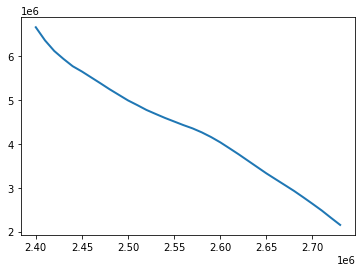

In [70]:
from matplotlib import pyplot as plt
plt.figure()

plt.plot(surge_path1.iloc[:,0], surge_path1.iloc[:,1], linewidth=2, label="Path1")
#plt.plot(surge_path2.iloc[:,0], surge_path2.iloc[:,1], linewidth=2, label="Path2")
#plt.plot(surge_path3.iloc[:,0], surge_path3.iloc[:,1], linewidth=2, label="Path3")

#plt.plot(surge_path2.iloc[:,1], surge_path2.iloc[:,0], linewidth=2, label="Path4")
#plt.plot(surge_path1.iloc[24,0], surge_path1.iloc[24,1], label="Eye_loc", color = "blue" )

In [62]:
print(ike.t)
ike.eye_location = ike.eye_location[19:53,]
ike.t = ike.t[19:53]
print(ike.t)
ike.max_wind_speed = ike.max_wind_speed[19:53]
ike.max_wind_radius = ike.max_wind_radius[19:53]
ike.central_pressure = ike.central_pressure[19:53]
ike.storm_radius = ike.storm_radius[19:53]
#ike.time_offset = datetime.datetime(2008, 9, 13, 7)
print(ike.t)


[datetime.datetime(2008, 9, 1, 6, 0), datetime.datetime(2008, 9, 1, 12, 0), datetime.datetime(2008, 9, 1, 18, 0), datetime.datetime(2008, 9, 2, 0, 0), datetime.datetime(2008, 9, 2, 6, 0), datetime.datetime(2008, 9, 2, 12, 0), datetime.datetime(2008, 9, 2, 18, 0), datetime.datetime(2008, 9, 3, 0, 0), datetime.datetime(2008, 9, 3, 6, 0), datetime.datetime(2008, 9, 3, 12, 0), datetime.datetime(2008, 9, 3, 18, 0), datetime.datetime(2008, 9, 4, 0, 0), datetime.datetime(2008, 9, 4, 6, 0), datetime.datetime(2008, 9, 4, 12, 0), datetime.datetime(2008, 9, 4, 18, 0), datetime.datetime(2008, 9, 5, 0, 0), datetime.datetime(2008, 9, 5, 6, 0), datetime.datetime(2008, 9, 5, 12, 0), datetime.datetime(2008, 9, 5, 18, 0), datetime.datetime(2008, 9, 6, 0, 0), datetime.datetime(2008, 9, 6, 6, 0), datetime.datetime(2008, 9, 6, 12, 0), datetime.datetime(2008, 9, 6, 18, 0), datetime.datetime(2008, 9, 7, 0, 0), datetime.datetime(2008, 9, 7, 6, 0), datetime.datetime(2008, 9, 7, 12, 0), datetime.datetime(2008, 

In [63]:
ike.eye_location[:,0]=surge_path1.iloc[:,0]
ike.eye_location[:,1]=surge_path1.iloc[:,1]
geoclaw_path = '/home/jovyan/data/hydroinformatics/syn_storm/Path1.storm'
ike.write(geoclaw_path, file_format='geoclaw')

ike.eye_location[:,0]=surge_path2.iloc[:,0]
ike.eye_location[:,1]=surge_path2.iloc[:,1]
geoclaw_path = '/home/jovyan/data/hydroinformatics/syn_storm/Path2.storm'
ike.write(geoclaw_path, file_format='geoclaw')

ike.eye_location[:,0]=surge_path3.iloc[:,0]
ike.eye_location[:,1]=surge_path3.iloc[:,1]
geoclaw_path = '/home/jovyan/data/hydroinformatics/syn_storm/Path3.storm'
ike.write(geoclaw_path, file_format='geoclaw')


In [ ]:

# Calculate landfall time - Need to specify as the file above does not
# include this info (9/13/2008 ~ 7 UTC)
ike.time_offset = datetime.datetime(2008, 9, 13, 7)
ike.write(data.storm_file, file_format='geoclaw')

In [ ]:
geoclaw_path = '/home/jovyan/data/hydroinformatics/syn_storm/ike2.storm'
ike = Storm(path=geoclaw_path, file_format='geoclaw')